#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Higher order finite difference methods

## Lagrange Interpolating Polynomials

Suppose we are given function values $u_0, \dotsc, u_n$ at the distinct points $x_0, \dotsc, x_n$ and we would like to build a polynomial of degree $n$ that goes through all these points.  This explicit construction is attributed to Lagrange (though he was not first):

$$ p(x) = \sum_{i=0}^n u_i \prod_{j \ne i} \frac{x - x_j}{x_i - x_j} $$

* What is the degree of this polynomial?
* Why is $p(x_i) = u_i$?
* How expensive (in terms of $n$) is it to evaluate $p(x)$?
* How expensive (in terms of $n$) is it to convert to standard form $p(x) = \sum_{i=0}^n a_i x^i$?
* Can we easily evaluate the derivative $p'(x)$?
* What can go wrong?  Is this formulation numerically stable?

<IPython.core.display.Javascript object>


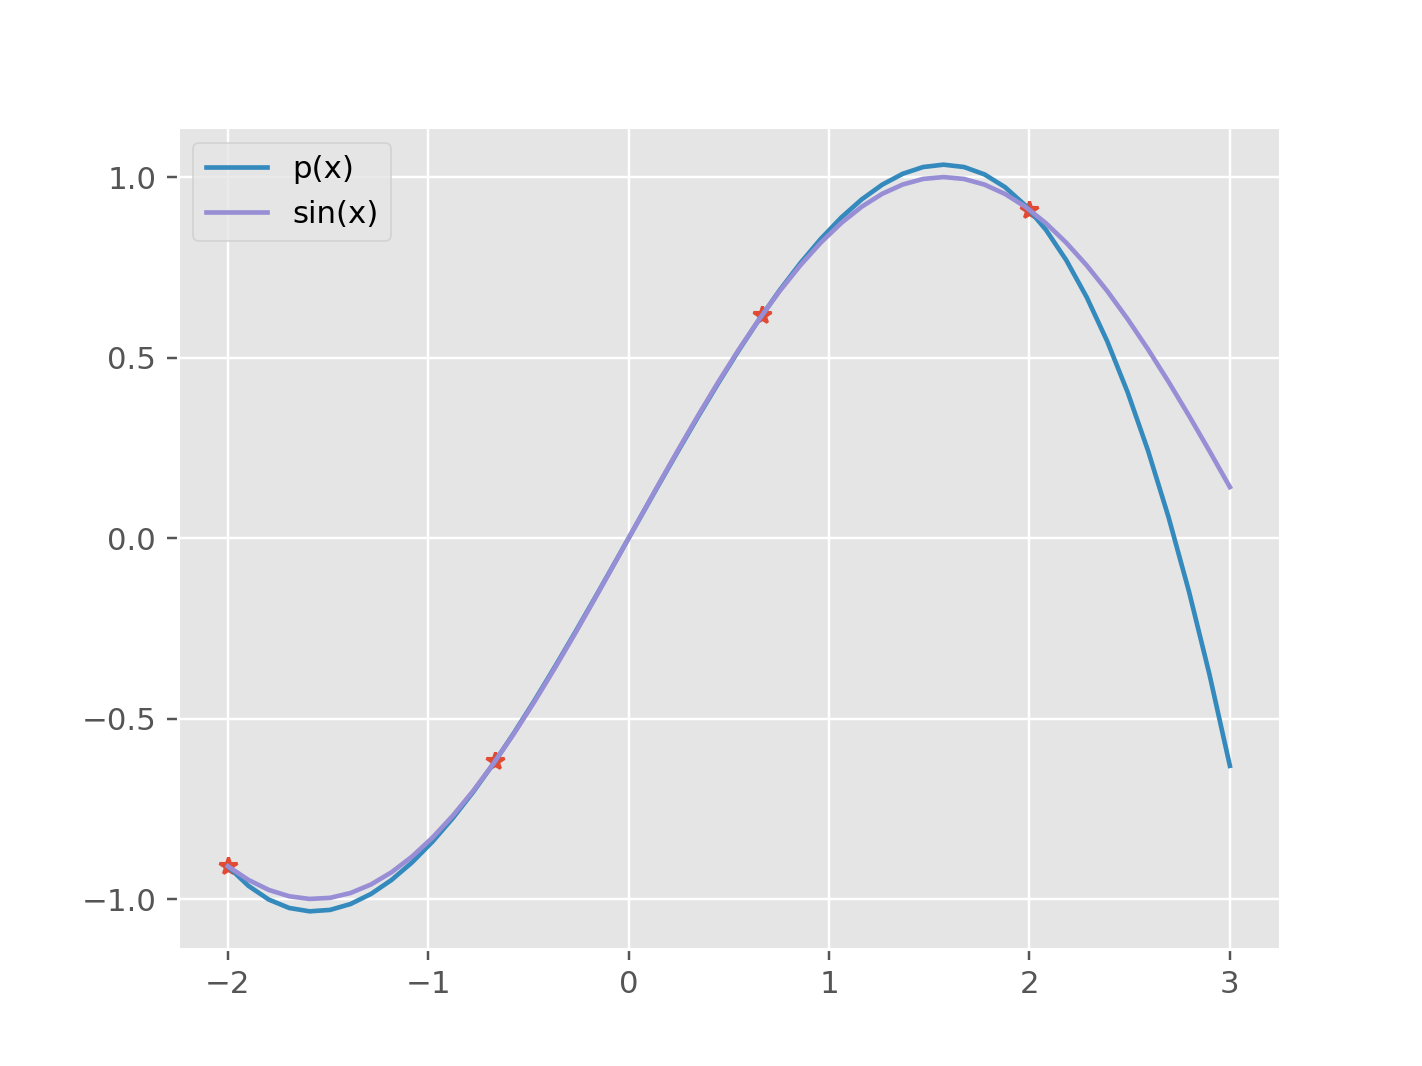

In [2]:
%matplotlib notebook
import numpy
from matplotlib import pyplot

def lagrange(x, y):
    def p(t):
        from numpy import prod
        m = len(x) - 1
        w = 0
        for i in range(m):
            w += y[i] * (prod(t - x[:i]) * prod(t - x[i+1:])
                / (prod(x[i] - x[:i]) * prod(x[i] - x[i+1:])))
        w += y[m] * prod(t - x[:m]) / prod(x[m] - x[:m])
        return w
    return numpy.vectorize(p)

x = numpy.linspace(-2,2,4)
y = numpy.sin(x)
p = lagrange(x, y)
xx = numpy.linspace(-2,3)
pyplot.style.use('ggplot')
pyplot.rcParams['figure.max_open_warning'] = False
pyplot.figure()
pyplot.plot(x, y, '*')
pyplot.plot(xx, p(xx), label='p(x)')
pyplot.plot(xx, numpy.sin(xx), label='sin(x)')
pyplot.legend(loc='upper left')
pyplot.show()

#### Uniqueness

Is the polynomial $p(x)$ of degree $m$ that interpolates $m+1$ points unique?  Why?

### Vandermonde matrices

Vandermonde matrices express a polynomial interpolation using a monomial basis.

<IPython.core.display.Javascript object>


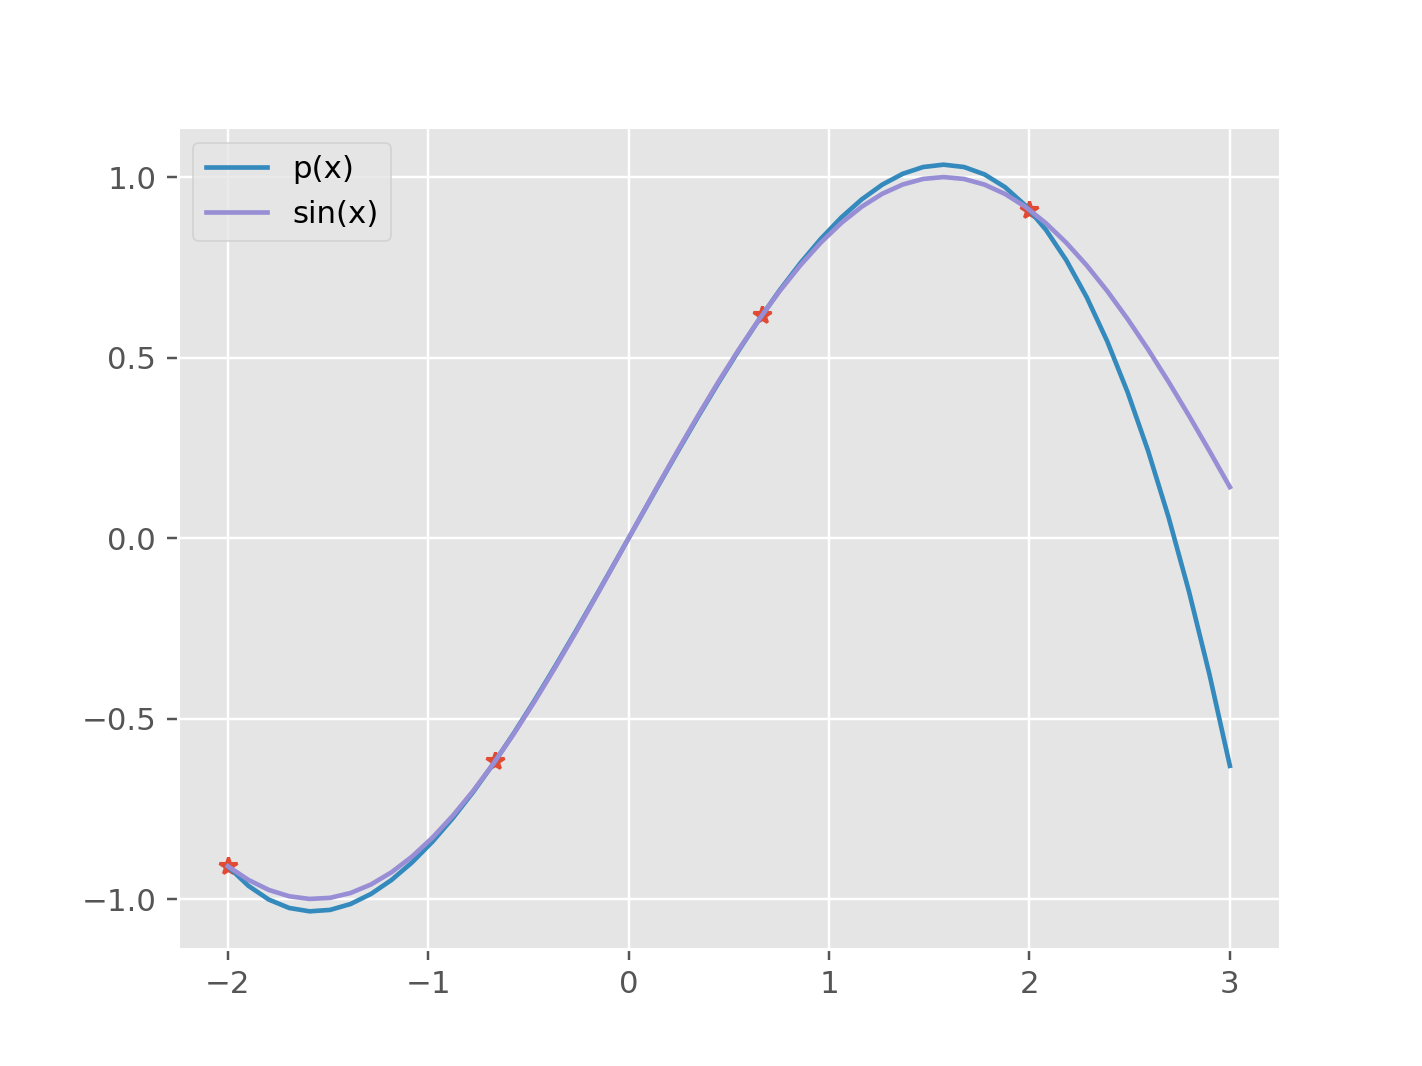

In [3]:
p = numpy.linalg.solve(numpy.vander(x), y)
pyplot.figure()
pyplot.plot(x, y, '*')
pyplot.plot(xx, numpy.vander(xx, 4).dot(p), label='p(x)')
pyplot.plot(xx, numpy.sin(xx), label='sin(x)')
pyplot.legend(loc='upper left')